In [1]:
%matplotlib inline

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.mat_gen import normal, uniform, _scale_spectral_radius

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, Bounds, basinhopping, brute
import scipy

In [2]:
# Section to reproduce 
# (if 0: reproduces Overview fig.1 ; if 1: reproduces section3.2 fig.12)
# The differences are (1) sequences p3 and p4 change, and (2) plots for singular values are different (number of values shown, C or R matrix, log or linear)
section = 1

seed = 430
rng = np.random.default_rng(seed)
rpy.set_seed(seed)


In [3]:
def conceptor_run(C, x0, W, b, n_timesteps=500):
    Z = np.zeros((n_timesteps, x0.size))
    X = np.zeros((n_timesteps, x0.size))
    
    x = x0
    for i in range(n_timesteps):
        z = np.tanh(x @ W + b)
        x = z @ C
        Z[i,:] = z
        X[i,:] = x
        
    return X,Z


In [4]:

N = 100

reservoir = Reservoir(
    N, 
    lr=1, 
    sr=1.5, 
    input_scaling=1.5, 
    bias_scaling=.2, 
    rc_connectivity=.1,
    W=uniform(low=-1,high=1), # not specified
    Win=normal(loc=0,scale=1),
    bias=normal(loc=0,scale=1),
    input_connectivity=1
)

readout = Ridge(ridge=.01, input_bias=False) # no bias is mentioned
recurrence = Ridge(ridge=.0001, input_bias=False) # we don't want to use a bias since we're looking for a weight matrix


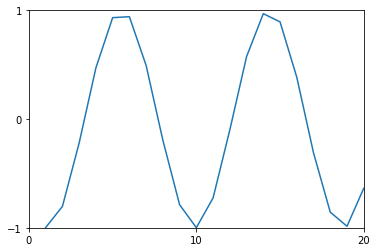

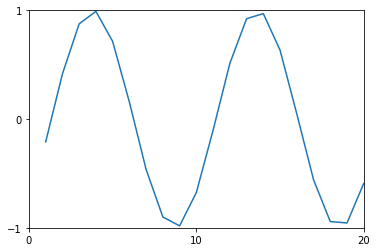

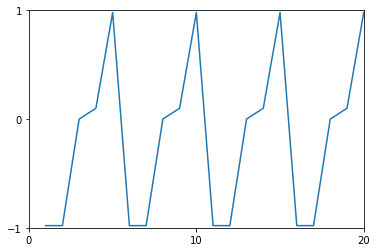

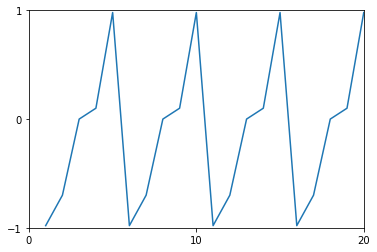

In [5]:
def plot_sequence(x, seq, n_timesteps=20, show=True, ax=plt, **kwargs):
    ax.plot(x[:n_timesteps], seq[:n_timesteps], **kwargs)
    if ax==plt:
        plt.xlim(0,n_timesteps)
        plt.xticks([0,10,n_timesteps])
        plt.ylim(-1,1)
        plt.yticks([-1,0,1])
    else:
        ax.set_xlim(0,n_timesteps)
        ax.set_xticks([0,10,n_timesteps])
        ax.set_ylim(-1,1)
        ax.set_yticks([-1,0,1])
    if show:
        plt.show()
    
    
x = np.arange(20*5000)+1
p1 = np.sin(2*np.pi*x/(8.83)).reshape(-1, 1)
p2 = np.sin(2*np.pi*x/(9.83)).reshape(-1, 1)

# Let's try to infer p3 and p4 used in Jaeger (2014) visually (just by looking at the figures)
p3 = np.array(([-.98,-.98,0,.1,.98] if section else [.98,-.98,-.05,-.5,.15])*4*5000).reshape(-1, 1)
p4 = np.array(([-.98,-.7,0,.1,.98] if section else [.98,-.98,-.6,-.5,.15])*4*5000).reshape(-1, 1)

sequences = [p1, p2, p3, p4]
for seq in sequences:
    plot_sequence(x, seq[500:])






# Train the readout

We train a readout to recognize all four sequences

In [6]:

X = np.array([reservoir.run(sequence[:1500], reset=True) for sequence in sequences])
Y = np.array([sequence[:1500] for sequence in sequences])
readout = readout.fit(X, Y, warmup=500)

Running Reservoir-0: 100%|██████████| 1500/1500 [00:00<00:00, 19478.80it/s]


Running Ridge-0: 100%|██████████| 2000/2000 [00:00<00:00, 50165.40it/s]


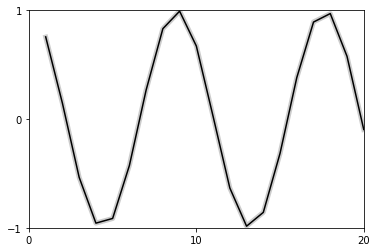

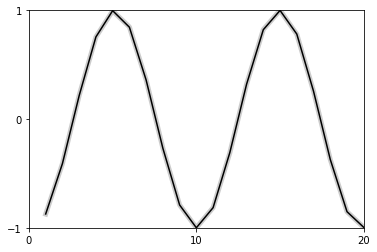

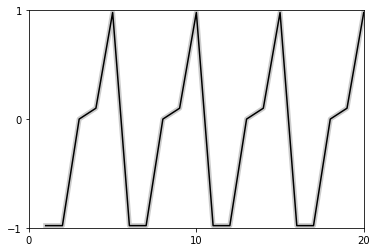

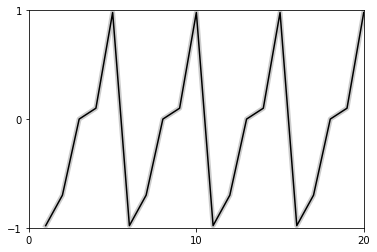

In [7]:
test_states = np.array([reservoir.run(sequence[:2000], reset=True) for sequence in sequences])
Y_pred = [readout.run(test_states[i]) for i in range(len(sequences))]
for i in range(len(sequences)):
    plot_sequence(x, sequences[i][1000:], show=False, color='black')
    plot_sequence(x, Y_pred[i][1000:], show=False, linewidth=5, alpha=.2, color='black')
    plt.show()


# Train the recurrence

We train a "readout" to find a new weight matrix for the reservoir that is able to reproduce the dynamics of the reservoir driven by the four sequences without the sequences being fed as input to the reservoir.

In [8]:
states = np.array([reservoir.run(sequence[:1501], reset=True) for sequence in sequences])
X = np.array([states[i][1:] for i in range(len(sequences))])
X_tilde = np.array([states[i][:-1] for i in range(len(sequences))]) # delayed states
b = reservoir.bias if type(reservoir.bias)==np.ndarray else reservoir.bias.toarray()
recurrence = recurrence.fit(X_tilde, np.arctanh(X)-b[:,0], warmup=499)

pred = np.array([recurrence.run(X_tilde[i][500:]) for i in range(len(sequences))])
truth = np.arctanh(X[:,500:,:])-b[:,0]

NRMSE = np.sqrt(((pred - truth)**2).mean()/(truth**2).mean())

print("The NRMSE is:",NRMSE, "(is 0.0011 in Jaeger (2014, p.162))")

Running Ridge-1: 100%|██████████| 1000/1000 [00:00<00:00, 13797.14it/s]


The NRMSE is: 0.003178600036926515 (is 0.0011 in Jaeger (2014, p.162))


We then create a copy of the reservoir with the new weight matrix

In [9]:
loaded_reservoir = reservoir.copy()
loaded_reservoir.set_param('W', recurrence.get_param('Wout'))

Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 23115.99it/s]


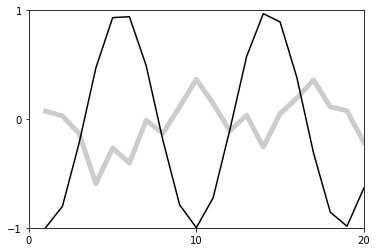

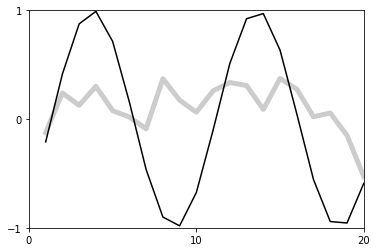

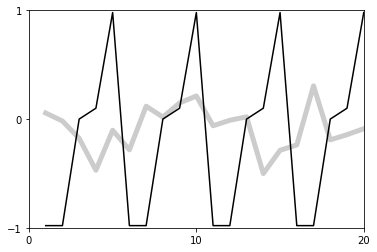

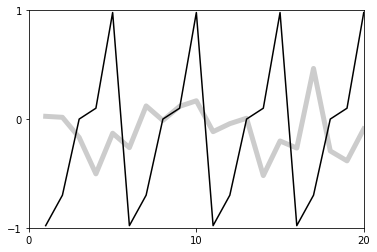

In [10]:
test_states = np.array([loaded_reservoir.run(np.zeros((500,1)), from_state=X[i][500,:]) for i in range(len(sequences))])
Y_pred = np.array([readout.run(test_states[i]) for i in range(len(sequences))])

for i in range(len(sequences)):
    plot_sequence(x, sequences[i][500:], show=False, color='black')
    plot_sequence(x, Y_pred[i][:], show=False, linewidth=5, alpha=.2, color='black')
    plt.show()


# Create a conceptor

In [11]:

def create_conceptor(states, warmup, aperture, return_R=False, thr_low=0, thr_hi=1):
    X = states[warmup:,:]
    R = np.dot(X.T,X)/X.shape[0] # correlation matrix
    C = np.matmul(R, np.linalg.pinv(R+np.identity(X.shape[1])/aperture**2))
    
    # zero small singular values and set large ones to one
    U,S,V = np.linalg.svd(C)
    S[np.where(S>thr_hi)] = 1
    S[np.where(S<thr_low)] = 0  
    C = np.dot(U*S, V)
    
    if return_R:
        return C,R
    return C


def plot_sv(mat, log, title="", ax=plt, show=True, n_values=None):
    if n_values is None:
        n_values = mat.shape[0]
    _,S,_ = np.linalg.svd(mat)
    if log:
        S = np.log10(S)
    
    ax.plot(S[:n_values], color='k')
    if ax==plt:
        plt.title(title)
    else:
        ax.set_title(title)
    if show:
        plt.show()


Now let's try to reproduce the sequences by filtering through the conceptors. 

**Note that it's okay if the reproduced pattern is offset**. Most importantly, the amplitude and "shape" of the sequences should be reproduced.

Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 23100.97it/s]


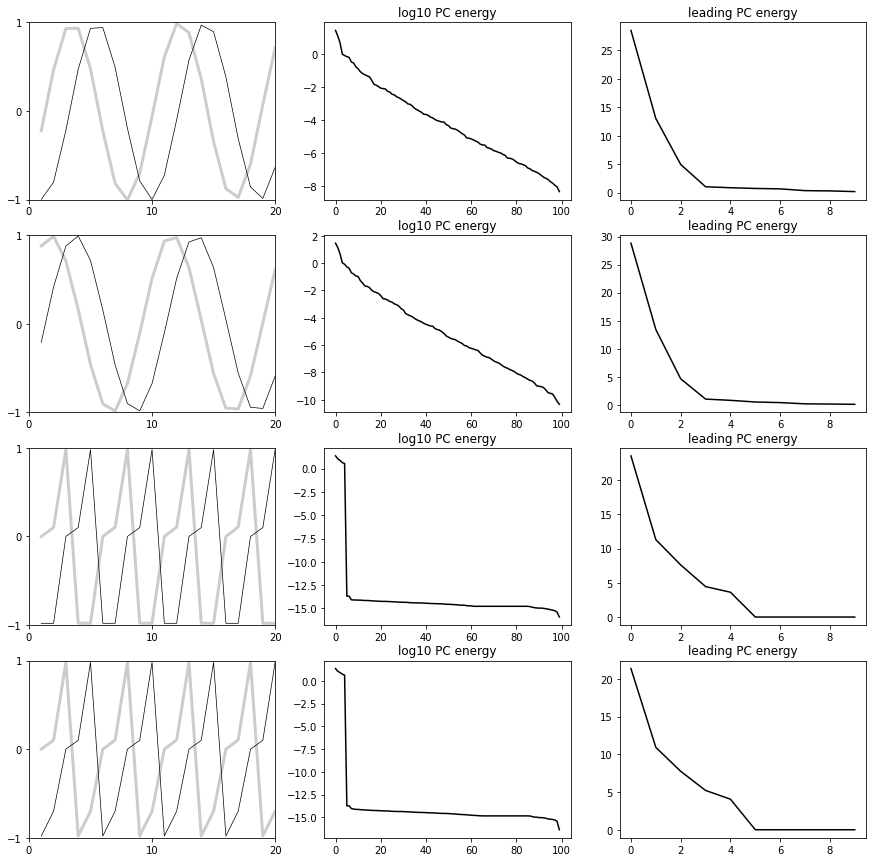

In [12]:
test_states = np.zeros(test_states.shape)
Y_pred = np.zeros(Y_pred.shape)

W = recurrence.get_param("Wout")
b = reservoir.get_param("bias")[:,0]

fig, axes = plt.subplots(nrows=len(sequences), ncols=3, figsize=(15,15))
for i in range(len(sequences)):
    
    C,R = create_conceptor(X[i,:,:], warmup=500, aperture=10, return_R=True)
    
    # compute filtered dynamics
    test_states,_ = conceptor_run(C, X[i,500], W, b, 500)
        
    # decode dynamics with readout
    Y_pred = readout.run(test_states)
    
    # plot singular values and signals
    plot_sv(R, log=True, title="log10 PC energy", ax=axes[i,1], show=False)
    if section:
        plot_sv(R, log=False, title="leading PC energy", ax=axes[i,2], show=False, n_values=10)
    else:
        plot_sv(C, log=False, title="s", ax=axes[i,2], show=False)
    plot_sequence(x, sequences[i][500:], show=False, ax=axes[i,0], color='black', linewidth=0.7)
    plot_sequence(x, Y_pred, show=False, ax=axes[i,0], linewidth=3, alpha=.2, color='black')


    
plt.show()


Now let's try to find a good aperture value for each sequence, using the attenuation minimization criterion.

Starting processing sequence 1


Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 19215.95it/s]

Starting processing sequence 2



Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 15898.35it/s]

Starting processing sequence 3



Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 21241.50it/s]

Starting processing sequence 4



Running Ridge-0: 100%|██████████| 500/500 [00:00<00:00, 21959.02it/s]


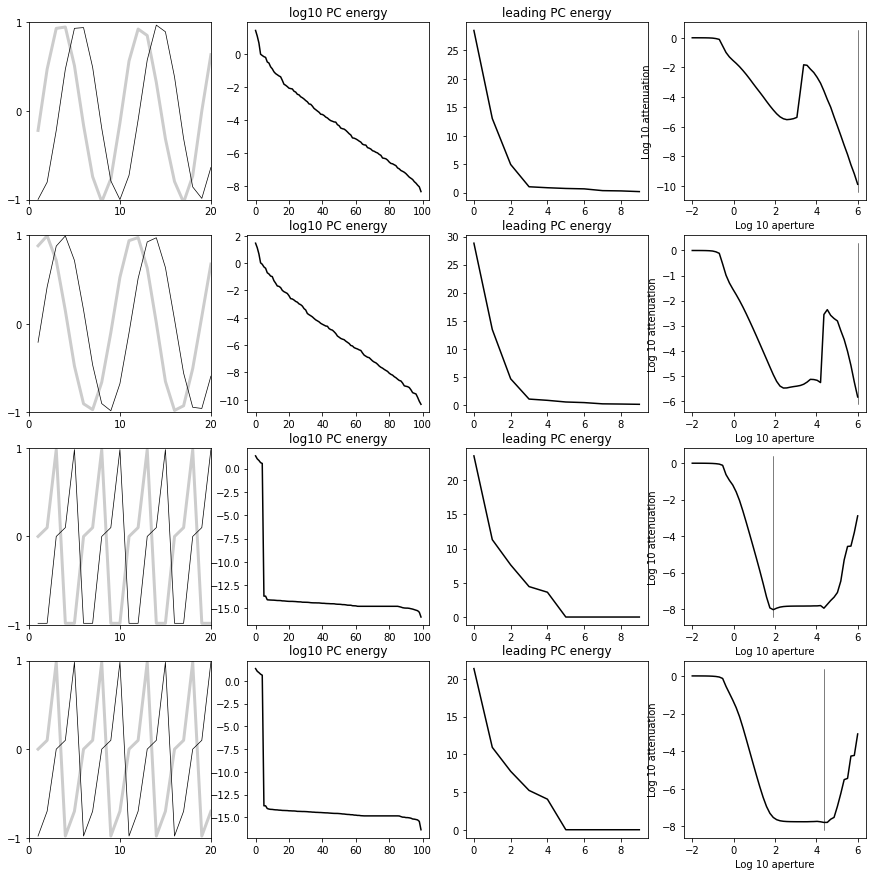

In [13]:
test_states = np.zeros(test_states.shape)
Y_pred = np.zeros(Y_pred.shape)

def attenuation(log10_aperture, sequence, x0, W, b, i):
    C,R = create_conceptor(sequence, warmup=500, aperture=10**log10_aperture, return_R=True)
    X,Z = conceptor_run(C, x0, W, b, 500)
    resulting_attenuation = np.mean(np.linalg.norm((Z-X), axis=1)**2)/np.mean(np.linalg.norm(Z, axis=1)**2)
    
    return resulting_attenuation


fig, axes = plt.subplots(nrows=len(sequences), ncols=4, figsize=(15,15))
for i in range(len(sequences)):
    
    print("Starting processing sequence", i+1)
    
    # create conceptor
#     minimizer_kwargs = {
#         "method": "L-BFGS-B",
#         "args": (X[i], X[i,500], W, b, i),
#         "bounds": ((-3,7),)
# #         "bounds": ((-2,4),)
#     }
#     results = basinhopping(
#         attenuation, 
#         2.1, 
#         niter=100,
#         minimizer_kwargs=minimizer_kwargs,
#         stepsize=5
#     )
    _,_,grid,Jout = brute(
        attenuation,
        ranges=((-2,6),),
        args=(X[i], X[i,500], W, b, i),
        Ns=50,
        full_output=True,
#         finish=None,
        workers=-1 # parallelize on all cores available
         
    )
    
    best_aperture = grid[np.argmin(Jout)]

    C,R = create_conceptor(X[i,:,:], warmup=500, aperture=10**best_aperture, return_R=True)
    
    # compute filtered dynamics
    test_states,_ = conceptor_run(C, X[i,500], W, b, 500)
        
    # decode dynamics with readout
    Y_pred = readout.run(test_states)
    
    # plot singular values and signals
    plot_sv(R, log=True, title="log10 PC energy", ax=axes[i,1], show=False)
    if section:
        plot_sv(R, log=False, title="leading PC energy", ax=axes[i,2], show=False, n_values=10)
    else:
        plot_sv(C, log=False, title="s", ax=axes[i,2], show=False)
    plot_sequence(x, sequences[i][500:], show=False, ax=axes[i,0], color='black', linewidth=0.7)
    plot_sequence(x, Y_pred, show=False, ax=axes[i,0], linewidth=3, alpha=.2, color='black')

    axes[i,3].plot(grid, np.log10(Jout), color='black')
    axes[i,3].plot([best_aperture]*2, list(axes[i,3].get_ylim()), color='black', linewidth=.5)
    axes[i,3].set_xlabel("Log 10 aperture")
    axes[i,3].set_ylabel("Log 10 attenuation")
    axes[i,3].plot(color='black')



plt.show()

From Jaeger (2014):
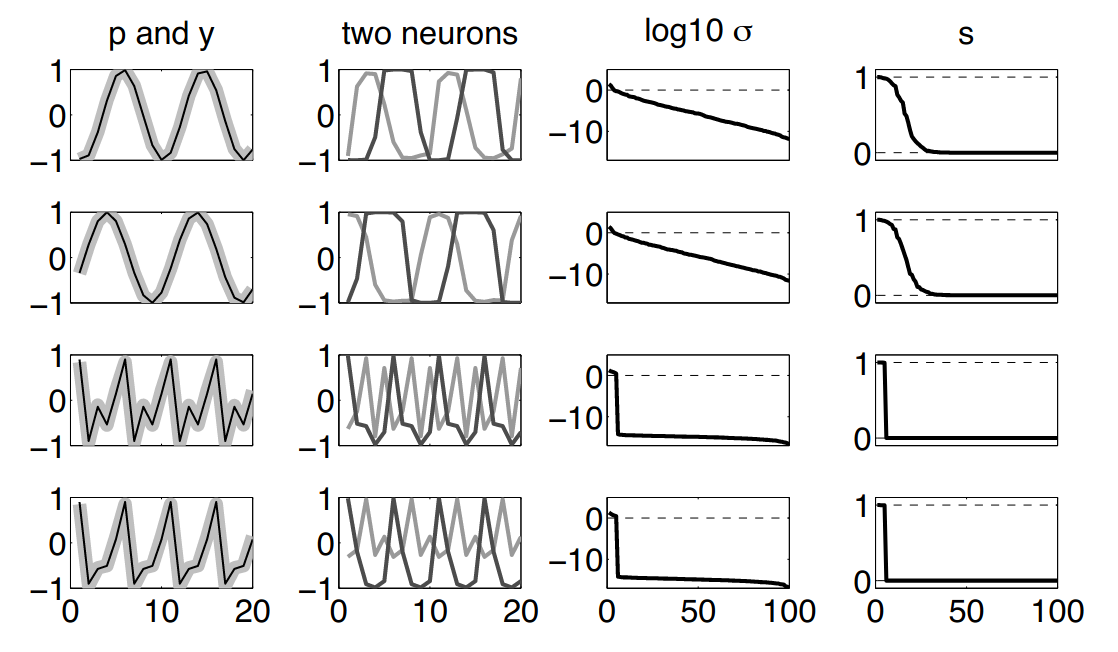
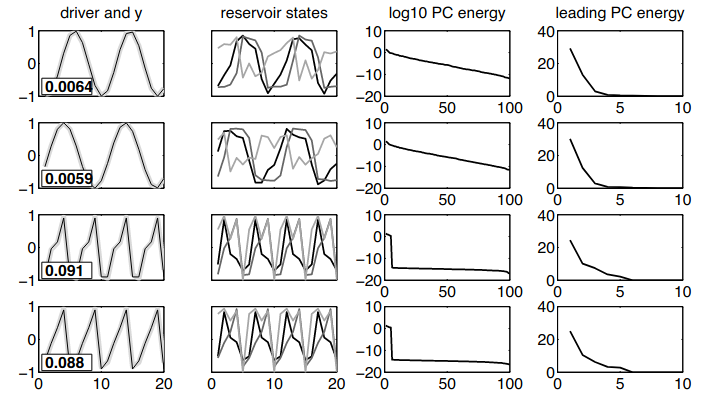